-Derivation of eigenvectors as PCAs:
https://www.cnblogs.com/lzllovesyl/p/5235137.html

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from statsmodels import regression
import statsmodels.api as sm
from scipy.sparse.linalg import eigs

In [2]:
allfactors = pd.read_csv('All_Factors.csv')
stock = pd.read_csv('stock.csv', index_col=0)
allfactors['date'] = pd.to_datetime(allfactors['date'])
stock['date'] = pd.to_datetime(stock['date']) + pd.offsets.MonthEnd(0) 
stock[stock['stock_id']==10001]['return'].plot()

#### keep only useful factors

In [3]:
allfactors.columns
ff = allfactors[['date','Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].set_index('date')

#### Loop to calculate residual series

In [4]:
vol_list = []
res_frame = pd.DataFrame()
X = sm.add_constant(ff)
# X is the factor matrix 
for stk in stock['stock_id'].unique():
    # for each stock we can run a OLS regression on the entire sample to get residual series 
    Y = stock[stock['stock_id']==stk][['date','return']].set_index('date')*100
    # Y is the monthly stock return (in %) indexed by date
    mod = regression.linear_model.OLS(Y, X).fit()
    # OLS regression
    residual = mod.resid
    # save residual series as 'residual'
    res_frame[stk] = residual/100
    # keep each residual series in a dataframe column
    variance = np.power(residual/100,2).mean()
    # 'variance' is approximately the sample variance of residual 
    annualized_vol = np.sqrt(variance*12)
    # 'annualized_vol' is the annualized volatility 
    vol_list.append(annualized_vol)
print('The average annualized volatility of the sample is {}'.format(np.mean(vol_list)))
res_frame.to_csv('residual.csv')
# save residuals to csv file

C:\Users\WENTWORTHLIU\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The average annualized volatility of the sample is 0.31570719250974416


#### Construct an estimated covariance matrix V

In [5]:
stock_num = len(res_frame.columns)
# get number of stocks in the sample
H = np.zeros((stock_num,stock_num))
# create nxn matrix to store variance covariance below
for i in range(len(res_frame)):
    vector = res_frame.iloc[i,:].values
    H += np.multiply.outer(vector,vector)
H = H/len(res_frame)
# calculate the average variance covariance matrix by looping through each date
# Alternatively, one can also use df.cov() to get H directly from residual dataframe: res_frame.cov()
Hframe = pd.DataFrame(H, index=res_frame.columns, columns =res_frame.columns)
# To covert matrix to dataframe, reverse way is to use df.values
Hframe.to_csv('covmatrix.csv')
# save covariance matrix 

#### PCA compoment analysis

##### First method: directly applying pca package on residual series

The explained variance ratios are: [0.03135796 0.02528947 0.01830387]


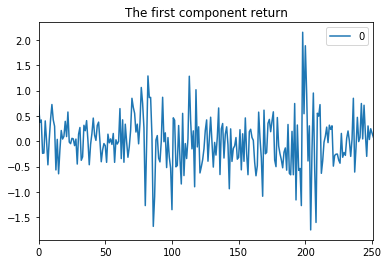

In [17]:
from sklearn.decomposition import PCA           
#加载PCA算法包
pca=PCA(n_components=3,whiten=False)     
#加载PCA算法，设置降维后主成分数目为3
# do not set whiten True because we want the linear combination of returns(features)
reduced_H=pca.fit_transform(res_frame)
#对样本进行降维
# note columns of reduced_H here are already combinations of returns, one must not confuse it with eigenvectors
print('The explained variance ratios are: {}'.format(pca.explained_variance_ratio_))
pd.DataFrame(reduced_H[:,0]).plot(title="The first component return")
# plot the first principle component of residual sereies

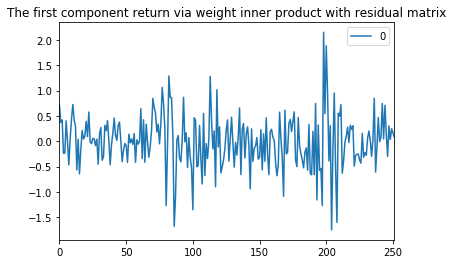

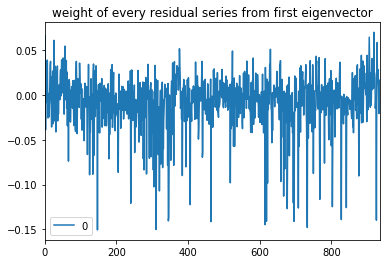

In [43]:
eigenvec = pca.components_[0,:]
pd.DataFrame(np.dot(res_frame, eigenvec)).plot(title="The first component return via weight inner product with residual matrix")
pd.DataFrame(eigenvec).plot(title="weight of every residual series from first eigenvector")
# 'pca.components_' returns the corresponded eigenvalue of the variance covariance matrix
# Therefore we can also construct the principle compoent in this way

##### Second method: calculate eigenvalues and vectors from H matrix of residual series

In [88]:
# Hframe = pd.read_csv('covmatrix.csv', index_col=0)
# Hframe=Hframe.astype(float)
egvalues, egvectors = eigs(Hframe.values, k=10)
# get eigen vectors with inner product of 1
egvalues.astype(float).sum()

#### Instead we can also do PCA for stock return series directly to figure out factors

The explained variance ratios are: [0.17981764 0.0316575  0.02434363]


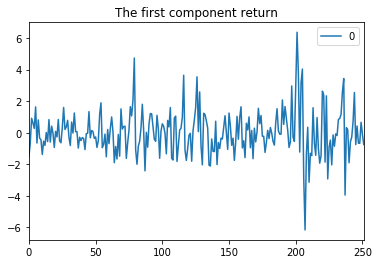

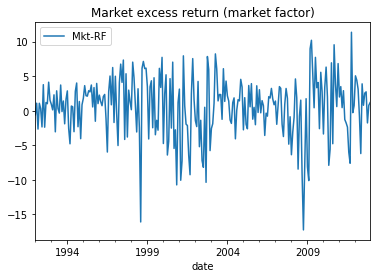

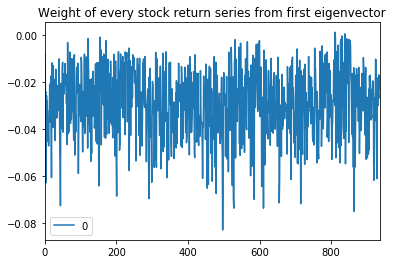

In [57]:
stock_frame=pd.pivot(stock, index='date', columns='stock_id',values='return')
pca=PCA(n_components=3,whiten=False)   
reduced_H=pca.fit_transform(stock_frame)
#对样本进行降维
# note columns of reduced_H here are already combinations of returns, one must not confuse it with eigenvectors
print('The explained variance ratios are: {}'.format(pca.explained_variance_ratio_))
pd.DataFrame(reduced_H[:,0]).plot(title="The first component return")
# plot the first principle component of residual sereies
ff[['Mkt-RF']].plot(title="Market excess return (market factor)")
# in contrast we can also plot market excess return
eigenvec = pca.components_[0,:]
pd.DataFrame(eigenvec).plot(title="Weight of every stock return series from first eigenvector")
# 'pca.components_' returns the corresponded eigenvalue of the variance covariance matrix
# Therefore we can also construct the principle compoent in this way